In [1]:
#import logging
from nblogger import logger, logging
from collections import OrderedDict, Iterable

import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt
from matplotlib import patches
import pandas

from ipywidgets import interact
import ipywidgets as widgets

import theano_shim as shim
import sinn
import sinn.histories as histories
from sinn.histories import Spiketrain, Series
import sinn.iotools as io
import sinn.analyze as anlz
from sinn.analyze.heatmap import HeatMap
import sinn.optimize.gradient_descent as gd

import main as main
import fsgif_model as fsgif

logging.getLogger().setLevel(100)
    # Remove output for final printout

np.set_printoptions(precision=5, suppress=True)
%matplotlib inline

pandas.options.display.latex.repr = True

2017-08-24 09:31:18,369 - sinn.analyze.stylelib.color_schemes - WARNING - [monochrome_palette]: value was greater than 1 and was clipped.


In [ ]:
%cd ..
main.load_parameters("main.params")

spikemodel = main.generate_spikes(
    20, filename='/home/alex/Recherche/data/mackelab/sim/fsGIF/short_adap/spikes/fsgif_no-input_20s_314seed')

main.compute_spike_activity(20)
None

mfmodel = main.derive_mf_model_from_spikes()

In [7]:
mfmodel.nbar.compute_up_to('end')

# Solving for the stationary state

Probably the most easily justifiable initial condition for our model would be to intialize in the stationary state. This state can be describe by the following self-consistency equation 

\begin{multline}
0 = 1 - A_{α}^{*} Δt \left\{
        k_{ref,α} + 1 + \sum_{i=k_{ref,α}}^{K-1} \exp \left[ - \sum_{j=k_{ref,α}+1}^{i-1} f(a_{αj} + b_{αj}^{β} A_{β}^{*} - c_{αj} A_{α}^{*}) Δt \right] \right. \\
        \left. + \frac {\exp \left[ - \sum_{j=k_{ref,α}}^{K-1} f(a_{αj} + b_{αj}^{β} A_{β}^{*} - c_{αj} A_α^*) Δt \right]}
                {1 - \exp \left[ - f({a'}_α + {b'}_α^β - {c'}_α A_α^*) Δt \right]}
    \right\}
\end{multline}
where
\begin{align}
a_{αj} &= 
   e^{-(j-k_{ref,α}+1) Δt / τ_{m,α}} (u_{r,α} - u_{rest,α}) + u_{rest,α} - u_{th,α} - θ_{α,j} \\
b_{αj}^β &=
   (1 - e^{-(j-k_{ref,α}+1)Δt/τ_{m,α}}) \frac{1 - e^{-Δt/τ_{m,β}}}{1 - e^{-Δt/τ_{m,α}}}τ_m p_{α}^{β} N^{β} w_{α}^{β} \\
c_{αj} &= J_{θ,α} e^{-T/τ_{θ,α}} + Δt \sum_{j'=j+1}^K \tilde{θ}_{α,j'} \\
a_{α}' &= u_{rest,α} - u_{th,α} \\
b_{α}^{\prime β} &= (1 - e^{-Δt/τ_m}) τ_m p_{α}^{β} N^{β} w_{α}^{β} \\
c_{α}' &= J_{θ,α} e^{-T/τ_{θ,α}}  \,.
\end{align}
In the equations above, the sums over β are implicit, indicated by alternated raised and lowered symbols.

Solving this $n$-d equation (where $n$ is the number of populations) for $A^*$ yields the stationary state activity in the case of no input and large $N$. While the result is exact in the $N=\infty$, it should also serve as a suitable initializer in the case of finite $N$. Once we have the stationary activity $A^*$, we can compute all other state variables using the equations in the writeup. This allows us to initialize the system in a consistent state.

This result also allows us to initialize the spiking model. A simple, and likely good enough approximation would be to treat them as decoupled Bernouilli neurons with effective firing rate $A^*$. If we want to make sure to respect the refractory effect, a slightly more involved approach would be to generate each neuron's first spike using $A^*$, and then use $\lambda_i^*$ (which depends on the time of last spike) as a firing rate.

## Verification of the result

We can check our result by comparing with a simulation that has relaxed to its stationary state. To ensure the initial condition is forgotten, we let it run for 18s simulation seconds, and then average over 1s (1000 bins) to remove the finite-size effect. We do this not only for $A^*$, but also for the state variables which are calculated from $A^*$.

In [10]:
params = mfmodel.params
class F:
    def __init__(self, model):
        self.model = model
    def __getitem__(self, α):
        def _f(u):
            if isinstance(u, Iterable):
                return np.array([self.model.f(ui)[α] for ui in u])
            else:
                return self.model.f(u)[α]
        return _f
f = F(mfmodel)
k_refs = np.rint(params.t_ref / mfmodel.dt).astype('int')
jarrs = [np.arange(k0, mfmodel.K) for k0 in k_refs]

def rhs(A):
    a = lambda α: ( np.exp(-(jarrs[α]-k_refs[α]+1)*mfmodel.dt/params.τ_m[α]) * (params.u_r[α] - params.u_rest[α]) 
          + params.u_rest[α] - params.u_th[α] - mfmodel.θ_dis.get_trace()[k_refs[α]-1:mfmodel.K-1,α] )

    b = lambda α: ( (1 - np.exp(-(jarrs[α]-k_refs[α]+1)*mfmodel.dt/params.τ_m[α]))[:,np.newaxis] 
          * params.τ_m[α] * params.p[α] * params.N * params.w[α] )

    θtilde_dis = lambda α: mfmodel.θtilde_dis.get_trace()[k_refs[α]-1:mfmodel.K-1,α] * params.N[α] # starts at j+1, ends at K incl.
    c = lambda α: params.J_θ[0,α] * np.exp(-mfmodel.memory_time/params.τ_θ[0,α]) + mfmodel.dt * np.cumsum(θtilde_dis(α)[::-1])[::-1]

    ap = lambda α: params.u_rest[α] - params.u_th[α]

    bp = lambda α: (1 - np.exp(-mfmodel.dt/params.τ_m[α])) * params.τ_m[α] * params.p[α] * params.N * params.w[α]

    cp = lambda α: params.J_θ[0,α] * np.exp(-mfmodel.memory_time/params.τ_θ[0,α])

    return ( (k_refs + 1).astype(float)
             + np.array( [ np.exp(- f[α](a(α) + (b(α) * A).sum(axis=-1) - c(α)*A[α])[:-1].cumsum()*mfmodel.dt).sum()
                          for α in range(len(params.N))])
             + np.array( [ ( np.exp(- f[α](a(α) + (b(α) * A).sum(axis=-1) - c(α)*A[α]).sum()*mfmodel.dt) 
                           / (1 - np.exp(-f[α](ap(α) + (bp(α)*A).sum(axis=-1) - cp(α)*A[α])*mfmodel.dt)) )
                         for α in range(len(params.N)) ] ).flatten()
           ) * A * mfmodel.dt - 1
        

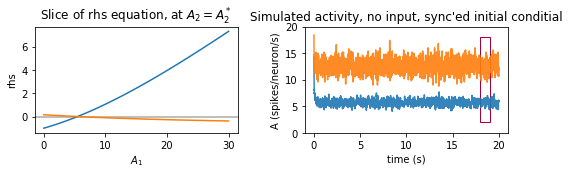

In [4]:
plt.figure(figsize=(8,2.5))

plt.subplot(1,2,1)
A1arr = np.linspace(0, 30)
Aarr = [np.array((A1, 12.536)) for A1 in A1arr]
plt.plot(A1arr, [rhs(A) for A in Aarr])
plt.axhline(0, color='#AAAAAA', zorder=-1)
plt.xlabel("$A_1$")
plt.ylabel("rhs")
plt.title("Slice of rhs equation, at $A_2 = A_2^*$")

plt.subplot(1,2,2)
plt.title("Simulated activity, no input, sync'ed initial conditial")
plt.xlabel("time (s)")
plt.ylabel("A (spikes/neuron/s)")
anlz.plot(anlz.smooth(mfmodel.A, 50), alpha=.9)
plt.ylim((0,20))
plt.gca().add_patch(
    patches.Rectangle(
        (18, 2),
        1,
        16,
        fill=False,
        color='#aa0036',
        zorder=-1))

plt.tight_layout()
None

We can solve this equation using SciPy's default root-finding method.

Aguess = np.array([10, 10])
res = root(rhs, Aguess)
A = res.x
print(A)

In [8]:
i=18000

In [21]:
htot = np.array([ (1 - np.exp(-mfmodel.dt/params.τ_m[α]))
                   * ( (1-np.exp(-mfmodel.dt/params.τ_m)) / (1-np.exp(-mfmodel.dt/params.τ_m[α]))
                       * params.τ_m[α] * params.p[α] * params.N * params.w[α] * Astar
                     ).sum(axis=-1)
                  for α in range(2)])
varθfree = params.u_th + params.J_θ*np.exp(-mfmodel.memory_time/params.τ_θ.flatten())*Astar
λfree = mfmodel.f(d['h'][0] - d['𝜗free'][0])
θtilde_dis = lambda α: mfmodel.θtilde_dis.get_trace()[k_refs[α]-1:mfmodel.K-1,α] * params.N[α] # starts at j+1, ends at K incl.

In [24]:
α = 1
a = lambda α: ( np.exp(-(jarrs[α]-k_refs[α]+1)*mfmodel.dt/params.τ_m[α]) * (params.u_r[α] - params.u_rest[α]) 
      + params.u_rest[α] - params.u_th[α] - mfmodel.θ_dis.get_trace()[k_refs[α]-1:mfmodel.K-1,α] )

b = lambda α: ( (1 - np.exp(-(jarrs[α]-k_refs[α]+1)*mfmodel.dt/params.τ_m[α]))[:,np.newaxis] 
      * params.τ_m[α] * params.p[α] * params.N * params.w[α] )

c = lambda α: params.J_θ[0,α] * np.exp(-mfmodel.memory_time/params.τ_θ[0,α]) + mfmodel.dt * np.cumsum(θtilde_dis(α)[::-1])[::-1]

ap = lambda α: params.u_rest[α] - params.u_th[α]

bp = lambda α: (1 - np.exp(-mfmodel.dt/params.τ_m[α])) * params.τ_m[α] * params.p[α] * params.N * params.w[α]

cp = lambda α: params.J_θ[0,α] * np.exp(-mfmodel.memory_time/params.τ_θ[0,α])

In [3]:
Astar = mfmodel.get_stationary_activity(mfmodel, mfmodel.K, 
                                        mfmodel.θ_dis, mfmodel.θtilde_dis)

s_state = mfmodel.get_stationary_state(Astar)

In [35]:
λprev = np.concatenate(
            ( np.zeros((1,) + s_state.λ.shape[1:]),
              s_state.λ[:-1] )  )
P = 1 - np.exp(-(s_state.λ+λprev)/2 *mfmodel.dt)
Pfree = 1 - np.exp(-s_state.λfree*mfmodel.dt)

η = get_η_csts(mfmodel.params, mfmodel.dt, mfmodel.K,
               mfmodel.θ_dis, mfmodel.θtilde_dis)

d = OrderedDict()
d['A'] = [None, mfmodel.A[i:i+1000].mean(axis=0), Astar]

d['h'] = [ np.array( [ params.u_rest[α] + (params.τ_m[α] * params.p[α] * params.N * params.w[α] * A).sum(axis=-1)
                       for α in range(2)]),
           mfmodel.h[i:i+1000].mean(axis=0),
           params.u_rest + η[0].dot(Astar) ]

d['htot'] = [ htot,
              mfmodel.h_tot[i:i+1000].mean(axis=0) - params.u_rest,
              η[1].dot(Astar) ]

d["𝜗free"] = [varθfree[0],
              mfmodel.varθfree[i:i+1000].mean(axis=0),
              params.u_th + η[6]*Astar ]

d["λfree"] = [ λfree,
               mfmodel.λfree[i:i+100].mean(axis=0),
               mfmodel.f( η[7] + η[0].dot(Astar) - η[6]*Astar) ]

d["Pfree"] = [ None,
               mfmodel.Pfree[i:i+1000].mean(axis=0),
               1 - np.exp(-d['λfree'][2]*mfmodel.dt) ]

d["x"] = [ None,
           mfmodel.x[i:i+1000].mean(axis=0),
           m_ss[-1] / d['Pfree'][2]]

d["z"] = [ None,
           mfmodel.z[i:i+1000].mean(axis=0),
           (d['x'][2] + v_ss[-1] / d['Pfree'][2]) / (2 - d['Pfree'][2]) ]

In [11]:
d = OrderedDict()
d['A'] = [Astar, mfmodel.A[i:i+1000].mean(axis=0)]

d['h'] = [ s_state.h,
           mfmodel.h[i:i+1000].mean(axis=0) ]

d['htot'] = [ s_state.h_tot,
              mfmodel.h_tot[i:i+1000].mean(axis=0) - params.u_rest ]

d["𝜗free"] = [ s_state.varθfree,
              mfmodel.varθfree[i:i+1000].mean(axis=0) ]

d["λfree"] = [ s_state.λfree,
               mfmodel.λfree[i:i+100].mean(axis=0) ]

d["x"] = [ s_state.x,
           mfmodel.x[i:i+1000].mean(axis=0) ]

d["z"] = [ s_state.z,
           mfmodel.z[i:i+1000].mean(axis=0) ]

In [12]:
for key, val in d.items():
    d[key] = [v.round(5) if v is not None else v for v in val]

In [15]:
df = pandas.DataFrame.from_dict(data=d, orient='index')
df.columns = ["theory", "simulation"]
df

,theory,simulation
A,"[5.47605, 12.53551]","[5.668, 12.72]"
h,"[18.12284, 19.24632]","[18.23714, 19.3629]"
htot,"[-0.09755, -0.05441]","[-0.09215, -0.04904]"
𝜗free,"[[15.10757, 15.0]]","[15.11168, 15.0]"
λfree,"[[18.27694, 23.37923]]","[18.66139, 23.32279]"
x,"[[0.00943, 0.0]]","[0.00887, 0.0]"
z,"[[0.0096, 0.0]]","[0.00453, 0.0]"


In [79]:
(vavg[-1] - mavg[-1]) / d['Pfree'][1] / (2 - d['Pfree'][1]) + d['x'][1]

ShimmedShared([ 0.008,  0.   ])

In [44]:
j = i
print( (1 - mfmodel.Pfree[j+1])**2 * mfmodel.z[j] 
                + mfmodel.Pfree[j+1]*mfmodel.x[j] + mfmodel.v[j+1][-1] )

print(mfmodel.z[j+1])

[ 0.00014  0.     ]
[ 0.00014  0.     ]


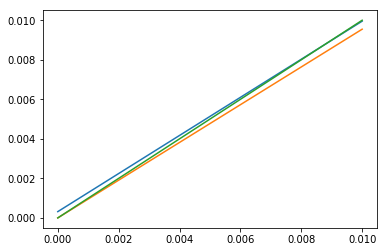

In [52]:
j = i
zarr = np.linspace(0,0.01)
plt.plot( zarr, ((1 - .99*d['Pfree'][1])**2 * zarr[:,np.newaxis]
                 + .99*d['Pfree'][1]*d['x'][1] + vavg[-1] ))

plt.plot(zarr, zarr)

In [66]:
imin = abs( ((1 - 1.3*d['Pfree'][1])**2 * zarr[:,np.newaxis]
                 + .7*d['Pfree'][1]*d['x'][1] + 0.7*vavg[-1] )[:,0] - zarr ).argmin()
zarr[imin]

0.0046938775510204081

In [127]:
np.array([mfmodel.z[i:i+nel].mean(axis=0) for nel in range(1,1000)]).shape

(999, 2)

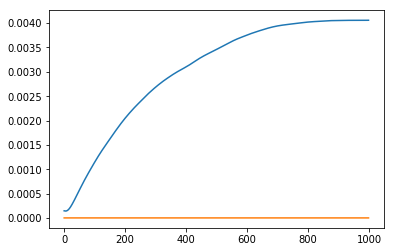

In [128]:
plt.plot([mfmodel.z[i:i+nel].mean(axis=0) for nel in range(1,1000)])

In [26]:
red_factor = lambda α: np.exp(-(jarrs[α]-k_refs[α]+1)*mfmodel.dt/params.τ_m[α])
u = np.transpose( [ 0 + red_factor(α) * params.u_r[α] 
                          + (1 - red_factor(α)) * params.u_rest[α]
                          + (1 - red_factor(α)) / (1 - np.exp(-mfmodel.dt/params.τ_m[α])) * htot[α]
                        for α in range(2) ] )

varθ = np.transpose([ params.u_th[α] + mfmodel.θ_dis.get_trace()[k_refs[α]-1:mfmodel.K-1,α]
            + ( params.J_θ[0,α] * np.exp(-mfmodel.memory_time/params.τ_θ[0,α]) 
                + mfmodel.dt * np.cumsum(θtilde_dis(α)[::-1])[::-1] 
              ) * Astar[α]
            for α in range(2) ])

λ = np.transpose([ [f[α](umv) for umv in (a(α) + (b(α) * Astar).sum(axis=-1) - c(α)*Astar[α])[:-1]]
                         for α in range(2)])

m = np.transpose([ np.exp(- f[α](a(α) + (b(α) * Astar).sum(axis=-1) - c(α)*Astar[α])[:-1].cumsum()*mfmodel.dt) * Astar[α] * mfmodel.dt * params.N[α]
                         for α in range(2)])

In [29]:
u = s_state.u
varθ = s_state.varθ
λ = s_state.λ
m = s_state.m

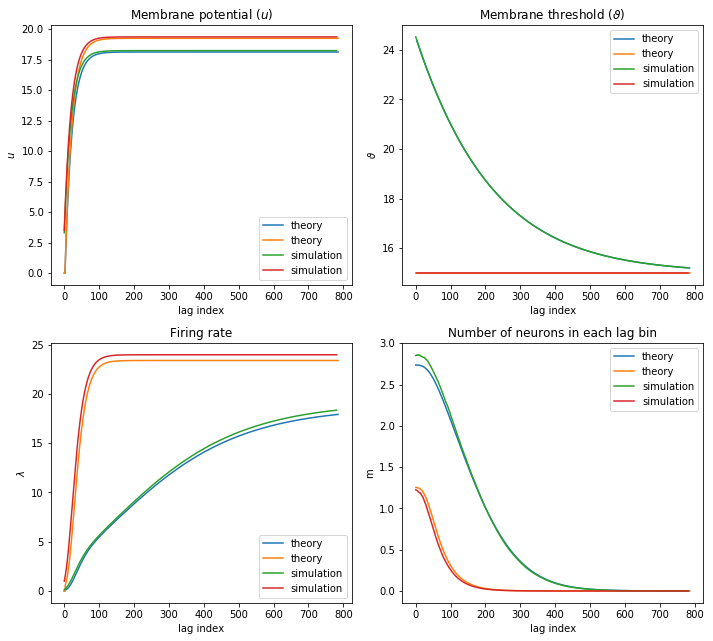

In [30]:
plt.figure(figsize=(10, 9))

plt.subplot(2,2,1)
plt.plot( u, label="theory")
plt.plot(np.transpose( [(mfmodel.u.get_trace()[i:i+1000, k_refs[α]:,α]).mean(axis=0)
                        for α in range(2)] ),
         label="simulation")
plt.title("Membrane potential ($u$)")
plt.xlabel("lag index")
plt.ylabel("$u$")
plt.legend()
#plt.ylim((15,20))
None

plt.subplot(2,2,2)
plt.plot( varθ, label="theory")
plt.plot( np.transpose([(mfmodel.varθ.get_trace()[i:i+1000,k_refs[α]:,α]).mean(axis=0) for α in range(2)]),
          label="simulation")
plt.ylabel("$\\vartheta$")
plt.title("Membrane threshold ($\\vartheta$)")
plt.xlabel("lag index")
plt.legend()
None

plt.subplot(2,2,3)
plt.plot(λ, label="theory")
plt.plot(np.transpose([(mfmodel.λ.get_trace()[i:i+1000,k_refs[α]:,α]).mean(axis=0)
                       for α in range(2)]),
         label="simulation")
plt.ylabel("$\\lambda$")
plt.title("Firing rate")
plt.xlabel("lag index")
plt.legend()
None

plt.subplot(2,2,4)
plt.plot(m, label="theory")
plt.plot(np.transpose([ mfmodel.m[i:i+1000][:,k_refs[α]:,α].mean(axis=0)
                        for α in range(2)]),
         label="simulation")
plt.title("Number of neurons in each lag bin")
plt.xlabel("lag index")
plt.ylabel("m")
plt.legend()

plt.tight_layout()

## State variable equations

$\newcommand{\ac}[1]{{}_{#1}{η}}$
$\newcommand{\coloneqq}{:=}$
\begin{align}
    h^{*}_{α} &= u_{rest,α} + \ac{1}_{α}^{β} A_{αβ}^{*} \\
    h_{tot,α}^{*} &= \ac{2}_{α}^{β} A_{αβ}^{*} \qquad \text{(see below)} \\
    u_{α,i}^{*} &= \ac{3}_{α,i} + \ac{4}_{α,i} \ac{2}_{α}^{β} A_{αβ}^{*} \\
    \vartheta_{α,i}^{*} &= \ac{5}_{α,i} + \ac{6}_{α,i} A_{α}^{*}  \\
    \vartheta_{free,α}^{*} &= u_{th,α} + \ac{7}_{α} A_{α}^{*}  \\
    λ_{free,α}^{*} &= f(\ac{8}_{α} + \ac{1}^{β} A_{αβ}^{*} - \ac{7}_{α} A_{α}^{*}) \\
    λ_{α,i}^{*} &= f(\ac{9}_{α,i} + \ac{10}_{α,i}^{β} A_{αβ}^{*} - \ac{6}_{α,i} A_{α}^{*}) \\
    P_{free,α}^{*} &= 1 - e^{-λ^{*}_{free,α} Δt} \\
    P_{α,i}^{*} &= 1 - e^{-λ_{α,i}^{*} Δt} \\
    \bar{m}_{α,i}^{*} &= 
    \begin{cases}
      A_{α}^{*} \, N_{α}\, dt & i = 0 \\
      [1 - P_{α,i}^{*}] \bar{m}_{α,i-1}^{*} & 0 < i \leq K
    \end{cases} \\
    v_{α,i}^{*} &= 
    \begin{cases}
      0 & i = 0 \\
      [1 - P_{α,i}^{*}]^2 v_{α,i-1}^{*} + P_{α,i}^{*} & 0 < i \leq K
    \end{cases} \\
    x_{α}^{*} &= \sum_{j=0}^{\infty} (1-P_{free}^{*})^{j} \bar{m}_{α,K}^{*} = \frac{\bar{m}_{α,K}^{*}}{P_{free}^{*}} \\
    z_{α}^{*} &= \frac{v_{α,K}^{*} - m_{α,K}^{*}}{P_{free,α}^{*} (2 - P_{free,α}^{*})} + x_{α}^{*}
\end{align}

Tensor constants:
\begin{align}
    \ac{1}_{α}^{β} &\coloneqq τ_{m,α} p_{α}^β N^{β} w_{α}^β \\
    \ac{2}_{α}^{β} &\coloneqq (1 - e^{-Δt/τ_{m,α}}) \ac{1}_{α}^{β}\\
    \ac{3}_{α,i} &\coloneqq
        \begin{cases}
           u_{r,α}  & 0 \leq i < k_{ref,α} \\
           e^{-(i-k_{ref,α}+1) Δt / τ_{m,α}} (u_{r,α} - u_{rest,α}) + u_{rest,α}  & i \geq k_{ref,α}
        \end{cases} \\
    \ac{4}_{α,i} &\coloneqq
         \begin{cases}
           0  & 0 \leq i < k_{ref,α} \\
           \frac{1 - e^{-(i-k_{ref,α}+1)Δt/τ_{m,α}}}{1 - e^{-Δt/τ_{m,α}}} &  i \geq k_{ref,α}
        \end{cases} \\
    \ac{5}_{α,i} &= u_{th,α} + θ_{α,i} \\
    \ac{6}_{α,i} &= J_{θ,α} e^{-T/τ_{θ,α}} + Δt \sum_{j=i+1}^K \tilde{θ}_{α,j} \\
    \ac{7}_{α} &= J_{θ,α} e^{-T/τ_{θ,α}} \\
    \ac{8}_{α} &\coloneqq u_{rest,α} - u_{th,α} \\
    \ac{9}_{αi} &\coloneqq \ac{3}_{αi} - \ac{5}_{αi} \\
    \ac{10}_{αi}^{β} &\coloneqq \ac{4}_{αi} \ac{2}_{α}^{β}
\end{align}

where $T \coloneqq K Δt$.

Finally, following the pseudocode implementation in [cite:Schwalger2016], in our code we actually have

$$h_{tot,α}^{*} = u_{rest,α} + \ac{2}_{α}^{β} A_{αβ}^{*} \,.$$

In [25]:
u_theory = η[2] + η[9].dot(Astar)

ucmp = np.empty((u.shape[0], 2*u.shape[1]))
ucmp[:,::2] = u
ucmp[:, 1::2] = u_theory[3:u.shape[0]+3]
ucmp[:10]

array([[ 0.88386,  0.88386,  0.93865,  0.93865],
       [ 1.72462,  1.72462,  1.83153,  1.83153],
       [ 2.52437,  2.52437,  2.68086,  2.68086],
       [ 3.28511,  3.28511,  3.48877,  3.48877],
       [ 4.00876,  4.00876,  4.25727,  4.25727],
       [ 4.69711,  4.69711,  4.98829,  4.98829],
       [ 5.35189,  5.35189,  5.68367,  5.68367],
       [ 5.97474,  5.97474,  6.34512,  6.34512],
       [ 6.56721,  6.56721,  6.97432,  6.97432],
       [ 7.13078,  7.13078,  7.57283,  7.57283]])

In [26]:
varθ_theory = η[4] + η[5]*Astar

varθcmp = np.empty((varθ.shape[0], 2*varθ.shape[1]))
varθcmp[:,::2] = varθ
varθcmp[:, 1::2] = varθ_theory[3:varθ.shape[0]+3]
varθcmp[:10]

array([[ 24.36898,  24.36953,  15.     ,  15.     ],
       [ 24.32674,  24.32728,  15.     ,  15.     ],
       [ 24.28467,  24.28521,  15.     ,  15.     ],
       [ 24.24277,  24.24331,  15.     ,  15.     ],
       [ 24.20105,  24.20159,  15.     ,  15.     ],
       [ 24.1595 ,  24.16004,  15.     ,  15.     ],
       [ 24.11812,  24.11866,  15.     ,  15.     ],
       [ 24.07691,  24.07746,  15.     ,  15.     ],
       [ 24.03588,  24.03642,  15.     ,  15.     ],
       [ 23.99501,  23.99556,  15.     ,  15.     ]])

In [27]:
η[8][:7]

ShimmedShared([[     -inf,      -inf],
               [     -inf,      -inf],
               [     -inf,      -inf],
               [-19.01859, -14.00693],
               [-18.06011, -13.0623 ],
               [-17.14728, -12.16374],
               [-16.27788, -11.309  ]])

In [24]:
η[2][:7]

array([[ 0.   ,  0.   ],
       [ 0.   ,  0.   ],
       [ 0.   ,  0.   ],
       [ 0.981,  0.993],
       [ 1.915,  1.938],
       [ 2.803,  2.836],
       [ 3.648,  3.691]])

In [25]:
η[4][:7]

ShimmedShared([[    inf,     inf],
               [    inf,     inf],
               [    inf,     inf],
               [ 20.   ,  15.   ],
               [ 19.975,  15.   ],
               [ 19.95 ,  15.   ],
               [ 19.926,  15.   ]])

In [26]:
mfmodel.θ_dis.get_trace()[:7]

array([[   inf,    inf],
       [   inf,    inf],
       [   inf,    inf],
       [ 5.   ,  0.   ],
       [ 4.975,  0.   ],
       [ 4.95 ,  0.   ],
       [ 4.926,  0.   ]])

In [28]:
λ_theory = np.stack( [ mfmodel.f(u) for u in η[8] + η[9].dot(Astar) - η[5]*Astar ] )

λcmp = np.empty((λ.shape[0], 2*λ.shape[1]))
λcmp[:,::2] = λ
λcmp[:, 1::2] = λ_theory[3:-2]
λcmp[:10]

array([[ 0.09122,  0.09121,  0.60069,  0.60069],
       [ 0.10884,  0.10883,  0.71813,  0.71813],
       [ 0.1288 ,  0.12879,  0.85108,  0.85108],
       [ 0.15123,  0.15121,  1.00034,  1.00034],
       [ 0.17625,  0.17623,  1.16654,  1.16654],
       [ 0.20395,  0.20393,  1.35019,  1.35019],
       [ 0.23442,  0.23439,  1.55165,  1.55165],
       [ 0.26771,  0.26768,  1.77112,  1.77112],
       [ 0.30387,  0.30384,  2.00862,  2.00862],
       [ 0.34292,  0.34288,  2.26404,  2.26404]])

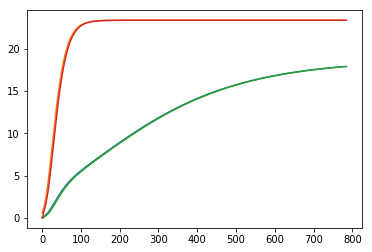

In [24]:
plt.plot(λ)
plt.plot(λ_theory)

In [29]:
λprev = np.concatenate(
            ( np.zeros((1,) + λ_theory.shape[1:]),
              λ_theory[:-1] ) )
λbar = (λ_theory + λprev)/2
P_theory = 1 - np.exp(-λbar*mfmodel.dt)

i=18000
K = P_theory.shape[0]
Pcmp = np.empty((K,2*P_theory.shape[1]))
Pavg = mfmodel.P_λ[i:i+1000].mean(axis=0)
Pcmp[:, ::2] = Pavg
Pcmp[:, 1::2] = P_theory
Pcmp[:10] * 1000

array([[ 0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.0611 ,  0.04561,  0.42692,  0.3003 ],
       [ 0.13292,  0.10002,  0.92921,  0.65919],
       [ 0.15563,  0.1188 ,  1.08861,  0.7843 ],
       [ 0.18089,  0.13999,  1.2656 ,  0.92528],
       [ 0.20881,  0.16371,  1.46062,  1.08285],
       [ 0.23945,  0.19006,  1.67399,  1.25757],
       [ 0.27287,  0.21913,  1.90585,  1.44987]])

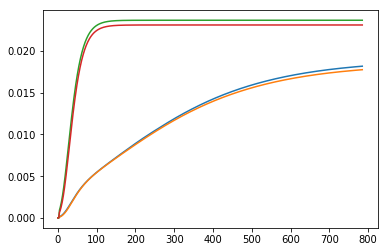

In [30]:
plt.plot(Pcmp)

In [31]:
K = s_state.m.shape[0]
m_ss = np.empty(P_theory.shape)
v_ss = np.empty(P_theory.shape)

mavg = mfmodel.m[i:i+1000].mean(axis=0)
vavg = mfmodel.v[i:i+1000].mean(axis=0)

m_ss[0] = Astar * params.N * mfmodel.dt
v_ss[0, :] = 0
vavg[0, :] = 0
for i in range(1, K):
    m_ss[i] = (1 - P_theory[i])*m_ss[i-1]
    v_ss[i] = (1 - P_theory[i])**2 * v_ss[i-1] + P_theory[i] * m_ss[i-1]

In [38]:
mcmp = np.empty((s_state.m.shape[0],2*P.shape[1]))
mcmp[:, ::2] = mfmodel.m[i:i+1000].mean(axis=0)
mcmp[:, 1::2] = s_state.m
mcmp[:10]

array([[ 2.845  ,  2.73803,  1.222  ,  1.25355],
       [ 2.847  ,  2.73803,  1.221  ,  1.25355],
       [ 2.845  ,  2.73803,  1.222  ,  1.25355],
       [ 2.84283,  2.7379 ,  1.22348,  1.25317],
       [ 2.85245,  2.73763,  1.22435,  1.25235],
       [ 2.856  ,  2.7373 ,  1.22302,  1.25137],
       [ 2.85448,  2.73692,  1.22148,  1.25021],
       [ 2.85788,  2.73647,  1.22071,  1.24885],
       [ 2.8572 ,  2.73595,  1.21769,  1.24728],
       [ 2.85741,  2.73535,  1.2134 ,  1.24548]])

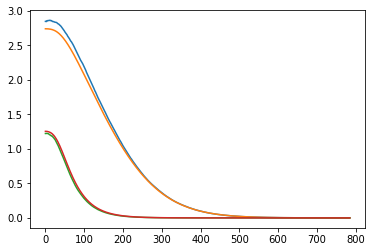

In [39]:
plt.plot(mcmp)

In [36]:
vcmp = np.empty((s_state.v.shape[0],2*P.shape[1]))
vcmp[:, ::2] = mfmodel.v[i:i+1000].mean(axis=0)
vcmp[:, 1::2] = s_state.v
vcmp[:10]*1000

array([[  0.     ,   0.     ,   0.     ,   0.     ],
       [  0.     ,   0.     ,   0.     ,   0.     ],
       [  0.     ,   0.     ,   0.     ,   0.     ],
       [  0.17403,   0.12487,   0.51988,   0.37644],
       [  0.55452,   0.39868,   1.65217,   1.20202],
       [  1.00056,   0.72383,   2.97319,   2.18235],
       [  1.51733,   1.10683,   4.50313,   3.33618],
       [  2.11688,   1.55452,   6.26655,   4.68275],
       [  2.80146,   2.07402,   8.26775,   6.2415 ],
       [  3.58213,   2.67265,  10.52293,   8.03181]])

In [35]:
mcmp[-1]

array([ 0.00016,  0.00017,  0.     ,  0.     ])

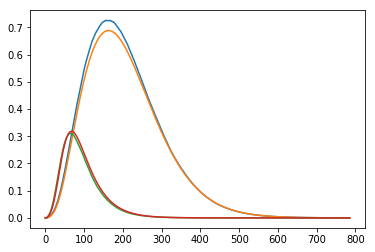

In [37]:
plt.plot(vcmp)

In [13]:
def get_η_csts(params, dt, K, θ, θtilde):
    """
    Returns the tensor constants which, along with the stationary activity,
    allow calculating the stationary value of each state variable. See the notebook
    'docs/Initial_condition.ipynb' for their definitions.

    Parameters
    ----------
    params: Parameters instance
        Must be compatible with GIF_mean_field.Parameters
    dt: float
        Time step. Typically [mean field model].dt
    K: int
        Size of the memory vector. Typically [mean field model].K
    θ, θtilde: Series
        Discretized kernels θ and θtilde.
    """
    Npop = len(params.N)
    τm = params.τ_m.flatten()
    τmT = τm[:,np.newaxis]  # transposed τ_m
    k_refs = np.rint(params.t_ref / dt).astype('int')
    jarrs = [np.arange(k0, K+1) for k0 in k_refs]
    memory_time = K*dt
    η = []
    η.append(τmT * params.p * params.N * params.w)  # η1
    η.append( (1 - np.exp(-dt/τmT)) * η[0] )        # η2
    η3 = np.empty((K, Npop))
    for α in range(Npop):
        red_factor = np.exp(-(jarrs[α]-k_refs[α]+1)*dt/params.τ_m[α])
        η3[:k_refs[α]-1, α] = params.u_r[α]
        η3[k_refs[α]-1:, α] = red_factor * (params.u_r[α] - params.u_rest[α]) + params.u_rest[α]
    η.append(η3)
    η4 = np.zeros((K, Npop))
    for α in range(Npop):
        η4[k_refs[α]-1:, α] = (1 - np.exp(- (jarrs[α] - k_refs[α] + 1)*dt / τm[α])) / (1 - np.exp(- dt / τm[α]))
    η.append(η4)
    η.append( params.u_th + θ.get_trace()[:K] )   # η5
    # TODO: remove params.N factor once it's removed in model
    η.append( params.J_θ * np.exp(-memory_time/params.τ_θ.flatten()) 
              + dt * params.N*np.cumsum(θtilde.get_trace()[K-1::-1], axis=0)[::-1] )   # η6
    η.append( params.J_θ * np.exp(-memory_time/params.τ_θ.flatten()) )  # η7
    η.append( params.u_rest - params.u_th )  # η8
    η.append( η[2] - η[4] )  # η9
    η.append( η[3][..., np.newaxis] * η[1] )  # η10

    return η

In [124]:
( params.u_th + mfmodel.θ_dis.get_trace()[:mfmodel.K] ).shape

(786, 2)

In [130]:
np.arange(10)[:7][::-1]

array([6, 5, 4, 3, 2, 1, 0])

In [132]:
np.arange(10)[6::-1]

array([6, 5, 4, 3, 2, 1, 0])